In [58]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import box
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from shapely.ops import unary_union
from tabulate import tabulate
import re

In [59]:
df = pd.read_csv('../data/feminicidios.csv')

df_2 = pd.read_csv('../data/Observatorio_Feminicidios_Colombia.csv', encoding='utf-8', sep=';')

colombia = gpd.read_file("../data/MGN2021_MPIO_POLITICO/MGN_MPIO_POLITICO.shp")

In [60]:
import unicodedata

def remove_accents_and_uppercase(text):
    if not isinstance(text, str):
        return text
    
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return text.upper()

columns_to_transform = ["tipo_violencia", "departamento", "municipio"]
columns_to_transform_colombia = ["DPTO_CNMBR", "MPIO_CNMBR"]

In [61]:
df_2[columns_to_transform]=df_2[columns_to_transform].applymap(remove_accents_and_uppercase)
colombia[columns_to_transform_colombia]=colombia[columns_to_transform_colombia].applymap(remove_accents_and_uppercase)

In [62]:
colombia.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUI,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048..."
3,05,021,05021,ANTIOQUIA,ALEJANDRIA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585..."
4,05,030,05030,ANTIOQUIA,AMAGA,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491..."


In [63]:
print(colombia.columns)

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR',
       'MPIO_CRSLC', 'MPIO_NAREA', 'MPIO_CSMBL', 'MPIO_VGNC', 'MPIO_TIPO',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


In [64]:
df_2.head()

,nro,ano,fecha_en_prensa,tipo_violencia,departamento,municipio
0,1,2018,2/01/2018,FEMINICIDIO,ANTIOQUIA,HISPANIA
1,2,2018,2/01/2018,FEMINICIDIO,META,
2,3,2018,3/01/2018,FEMINICIDIO,ANTIOQUIA,MEDELLIN
3,4,2018,3/01/2018,FEMINICIDIO,ANTIOQUIA,MEDELLIN
4,5,2018,3/01/2018,FEMINICIDIO,ANTIOQUIA,MEDELLIN


In [65]:
# Cambiar el nombre de la primera columna a 'numero'
df_2 = df_2.rename(columns={'nro': 'numero'})

# Convertir la columna 'ano' en numérica
df_2['ano'] = df_2['ano'].astype(int)

In [66]:
# Convierte la columna 'fecha_en_prensa' a tipo fecha, convirtiendo valores inválidos a NaN
df_2['fecha_en_prensa'] = pd.to_datetime(df_2['fecha_en_prensa'], errors='coerce', dayfirst=True)

# Elimina los registros con valores NaN en la columna 'fecha_en_prensa'
df_2 = df_2.dropna(subset=['fecha_en_prensa'])

# Verifica los cambios con .head()
print(df_2.head())

   numero   ano fecha_en_prensa tipo_violencia departamento municipio
0       1  2018      2018-01-02    FEMINICIDIO    ANTIOQUIA  HISPANIA
1       2  2018      2018-01-02    FEMINICIDIO         META          
2       3  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN
3       4  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN
4       5  2018      2018-01-03    FEMINICIDIO    ANTIOQUIA  MEDELLIN


Verificar la cantidad de registros y columnas de los DataFrames

In [67]:
comparison_df = pd.DataFrame({
    'DataFrame': ['feminicidios', 'Observatorio_Feminicidios_Colombia'],
    'Filas': [df.shape[0], df_2.shape[0]],
    'Columnas': [df.shape[1], df_2.shape[1]]
})


# Imprimir la tabla identada
print(tabulate(comparison_df, headers='keys', tablefmt='pretty'))

+---+------------------------------------+-------+----------+
|   |             DataFrame              | Filas | Columnas |
+---+------------------------------------+-------+----------+
| 0 |            feminicidios            | 2181  |    25    |
| 1 | Observatorio_Feminicidios_Colombia | 3107  |    6     |
+---+------------------------------------+-------+----------+


Verificar la distribución de los valores en cada columna

In [68]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   HECHO                       2181 non-null   object
 1   RUPTURA                     2181 non-null   object
 2   CONEXO                      2181 non-null   object
 3   ESTADO_NOTICIA              2181 non-null   object
 4   ETAPA                       2181 non-null   object
 5   ANIO_DENUNCIA               2181 non-null   int64 
 6   ANIO_ENTRADA                2181 non-null   int64 
 7   ANIO_HECHO                  2181 non-null   int64 
 8   LEY                         2181 non-null   object
 9   PAIS                        2181 non-null   object
 10  DEPARTAMENTO                2181 non-null   object
 11  MUNICIPIO                   2181 non-null   object
 12  SECCIONAL                   2179 non-null   object
 13  GRUPO_DELITO                2181 non-null   obje

In [69]:
df_2.describe()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 0 to 3110
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   numero           3107 non-null   int64         
 1   ano              3107 non-null   int32         
 2   fecha_en_prensa  3107 non-null   datetime64[ns]
 3   tipo_violencia   3107 non-null   object        
 4   departamento     3107 non-null   object        
 5   municipio        3022 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 157.8+ KB


Identificar y eliminar los valores faltantes

In [70]:
# Crear un DataFrame sin la columna 'municipio'
df_2_sin_municipio = df_2.drop(columns=['municipio'])

# Encontrar campos vacíos o nulos en el DataFrame sin la columna 'municipio'
missing_values = df_2_sin_municipio.isna().sum()

# Mostrar los campos vacíos o nulos
print(missing_values[missing_values > 0])


Series([], dtype: int64)


Filtrar el DataFrame para incluir solo registros con valores faltantes en `fecha_en_prensa`:

In [71]:
# Reemplazar los campos de municipio con solo espacios por NaN
df_2['municipio'] = df_2['municipio'].str.strip().replace('', np.nan)

# Filtrar el DataFrame para incluir solo registros con valores faltantes en 'municipio'
missing_municipio_df = df_2[df_2['municipio'].isna()]

# Contar registros con valores faltantes en 'municipio' agrupados por 'ano' y 'tipo_violencia'
missing_municipio_count = missing_municipio_df.groupby(['ano', 'tipo_violencia']).size().reset_index(name='municipios_vacios')

# Muestra el número de registros por año y por tipo de violencia
registros_por_ano_y_tipo = df_2.groupby(['ano', 'tipo_violencia']).size().reset_index(name='cantidad')

# Combinar los conteos de registros y los conteos de municipios vacíos en una sola tabla
registros_por_ano_y_tipo = registros_por_ano_y_tipo.merge(missing_municipio_count, on=['ano', 'tipo_violencia'], how='left')

# Rellenar con 0 los valores NaN en la columna 'municipios_vacios'
registros_por_ano_y_tipo['municipios_vacios'] = registros_por_ano_y_tipo['municipios_vacios'].fillna(0).astype(int)

# Mostrar la tabla
print(tabulate(registros_por_ano_y_tipo, headers='keys', tablefmt='pretty'))


+---+------+------------------+----------+-------------------+
|   | ano  |  tipo_violencia  | cantidad | municipios_vacios |
+---+------+------------------+----------+-------------------+
| 0 | 2018 |   FEMINICIDIO    |   658    |        512        |
| 1 | 2018 | TRANSFEMINICIDIO |    8     |         5         |
| 2 | 2019 |   FEMINICIDIO    |   562    |        420        |
| 3 | 2019 | TRANSFEMINICIDIO |    12    |         8         |
| 4 | 2020 |   FEMINICIDIO    |   613    |        290        |
| 5 | 2020 | TRANSFEMINICIDIO |    14    |         8         |
| 6 | 2021 |   FEMINICIDIO    |   604    |         3         |
| 7 | 2021 | TRANSFEMINICIDIO |    17    |         0         |
| 8 | 2022 |   FEMINICIDIO    |   598    |         0         |
| 9 | 2022 | TRANSFEMINICIDIO |    21    |         0         |
+---+------+------------------+----------+-------------------+


In [72]:
df.dropna()
df_2_mun_pop= df_2.dropna()

# Encuentra el municipio más popular por departamento
municipio_popular_por_departamento = df_2.groupby('departamento')['municipio'].agg(lambda x: x.value_counts().idxmax() if not x.empty and not x.value_counts().empty else None)

# Convertir la serie en un DataFrame
municipio_popular_por_departamento_df = municipio_popular_por_departamento.reset_index()

# Mostrar la tabla
print(tabulate(municipio_popular_por_departamento_df, headers='keys', tablefmt='pretty'))

# Define una función para llenar los campos vacíos en la columna "municipio"
def fill_municipio(row):
    if pd.isna(row['municipio']):
        return municipio_popular_por_departamento[row['departamento']]
    else:
        return row['municipio']

# Crea una copia de df_2 y aplica la función para llenar los campos vacíos en la columna "municipio"
df_2_copy = df_2.copy()
df_2_copy['municipio'] = df_2_copy.apply(fill_municipio, axis=1)
df_2_copy=df_2_copy.dropna()

+----+--------------------+------------------------+
|    |    departamento    |       municipio        |
+----+--------------------+------------------------+
| 0  |     ANTIOQUIA      |        MEDELLIN        |
| 1  |       ARAUCA       |        SARAVENA        |
| 2  |     ATLANTICO      |      BARRANQUILLA      |
| 3  |    BOGOTA D.C.     |      BOGOTA D.C.       |
| 4  |      BOLIVAR       |       CARTAGENA        |
| 5  |       BOYACA       |         TUNJA          |
| 6  |       CALDAS       |       MANIZALES        |
| 7  |      CAQUETA       |  SAN JOSE DEL FRAGUA   |
| 8  |      CASANARE      |         YOPAL          |
| 9  |       CAUCA        | SANTANDER DE QUILICHAO |
| 10 |       CESAR        |       VALLEDUPAR       |
| 11 |       CHOCO        |         QUIBDO         |
| 12 |      CORDOBA       |        MONTERIA        |
| 13 |    CUNDINAMARCA    |         SOACHA         |
| 14 |      GUAJIRA       |         MAICAO         |
| 15 |      GUAVIARE      |        CALAMAR    

Visualizar la distribución de los valores de una columna específica

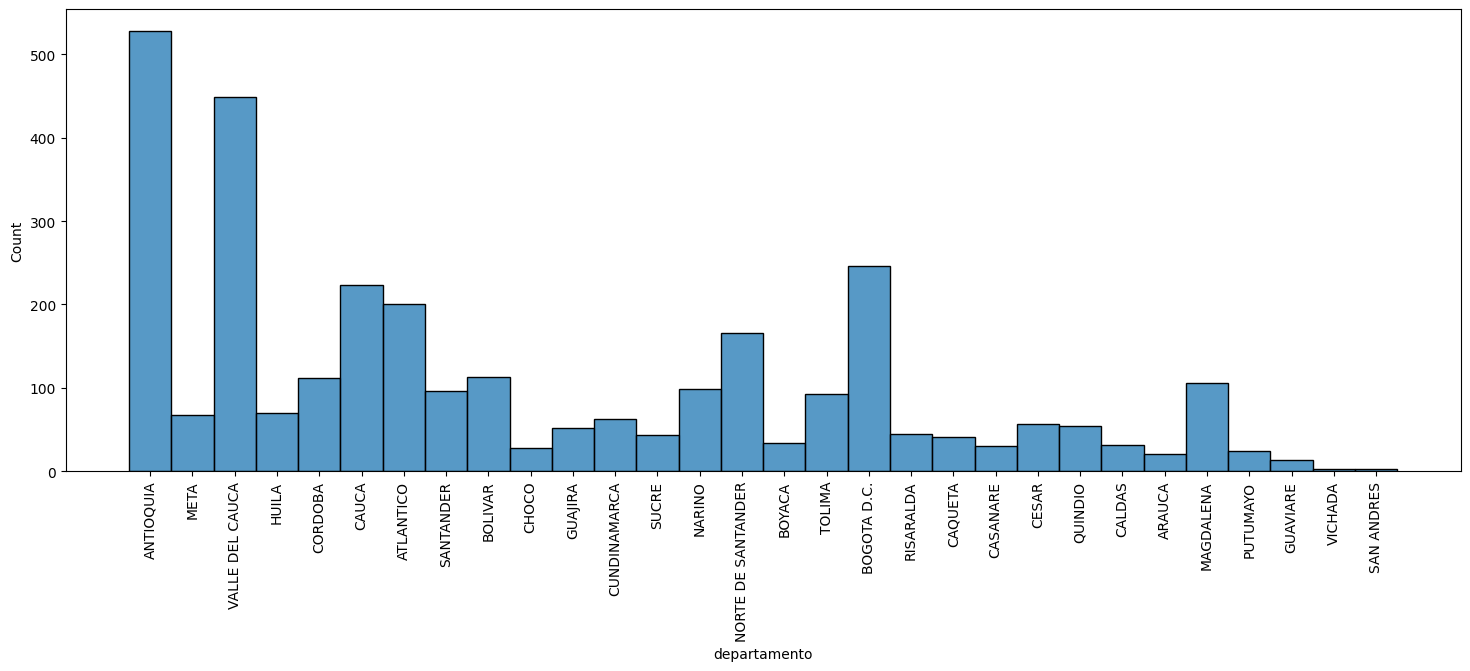

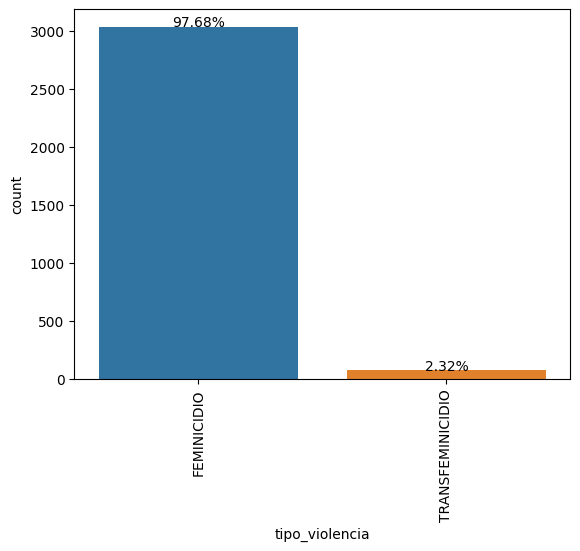

In [73]:
# Histograma para la columna "Departamento"
sns.histplot(data=df_2_copy, x='departamento', kde=False)
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejorar la legibilidad
plt.gcf().set_size_inches(18, 6)  # Cambiar el tamaño de la figura (ancho, alto) en pulgadas
plt.show()

# Gráfico de barras para la columna "tipo_violencia"
ax = sns.countplot(data=df_2_copy, x='tipo_violencia')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mejorar la legibilidad

# Calcular y mostrar porcentajes en el gráfico de barras
total = len(df_2_copy)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            '{:1.2f}%'.format(height / total * 100),
            ha="center")

plt.show()

Identificar cualquier correlación entre las diferentes columnas

In [74]:
# Codificar columnas categóricas como números enteros
encoder = LabelEncoder()
df_2_copy['ano_encoded'] = encoder.fit_transform(df_2_copy['ano'])
df_2_copy['fecha_en_prensa_encoded'] = encoder.fit_transform(df_2_copy['fecha_en_prensa'])
df_2_copy['tipo_violencia_encoded'] = encoder.fit_transform(df_2_copy['tipo_violencia'])
df_2_copy['departamento_encoded'] = encoder.fit_transform(df_2_copy['departamento'])
df_2_copy['municipio_encoded'] = encoder.fit_transform(df_2_copy['municipio'])

# Seleccionar solo las columnas codificadas
columns_to_include = ['ano_encoded', 'fecha_en_prensa_encoded', 'tipo_violencia_encoded', 'departamento_encoded', 'municipio_encoded']

In [75]:
# Calcular la correlación de Spearman y Kendall
spearman_corr = df_2_copy[columns_to_include].corr(method='spearman')
kendall_corr = df_2_copy[columns_to_include].corr(method='kendall')

print("Correlación de Spearman:")
print(spearman_corr)
print("\nCorrelación de Kendall:")
print(kendall_corr)

Correlación de Spearman:
                         ano_encoded  fecha_en_prensa_encoded   
ano_encoded                 1.000000                 0.977789  \
fecha_en_prensa_encoded     0.977789                 1.000000   
tipo_violencia_encoded      0.048058                 0.042512   
departamento_encoded       -0.020634                -0.022528   
municipio_encoded          -0.034825                -0.029270   

                         tipo_violencia_encoded  departamento_encoded   
ano_encoded                            0.048058             -0.020634  \
fecha_en_prensa_encoded                0.042512             -0.022528   
tipo_violencia_encoded                 1.000000              0.035478   
departamento_encoded                   0.035478              1.000000   
municipio_encoded                     -0.035474              0.015715   

                         municipio_encoded  
ano_encoded                      -0.034825  
fecha_en_prensa_encoded          -0.029270  
tipo_viole

Heatmap para la correlación de Spearman

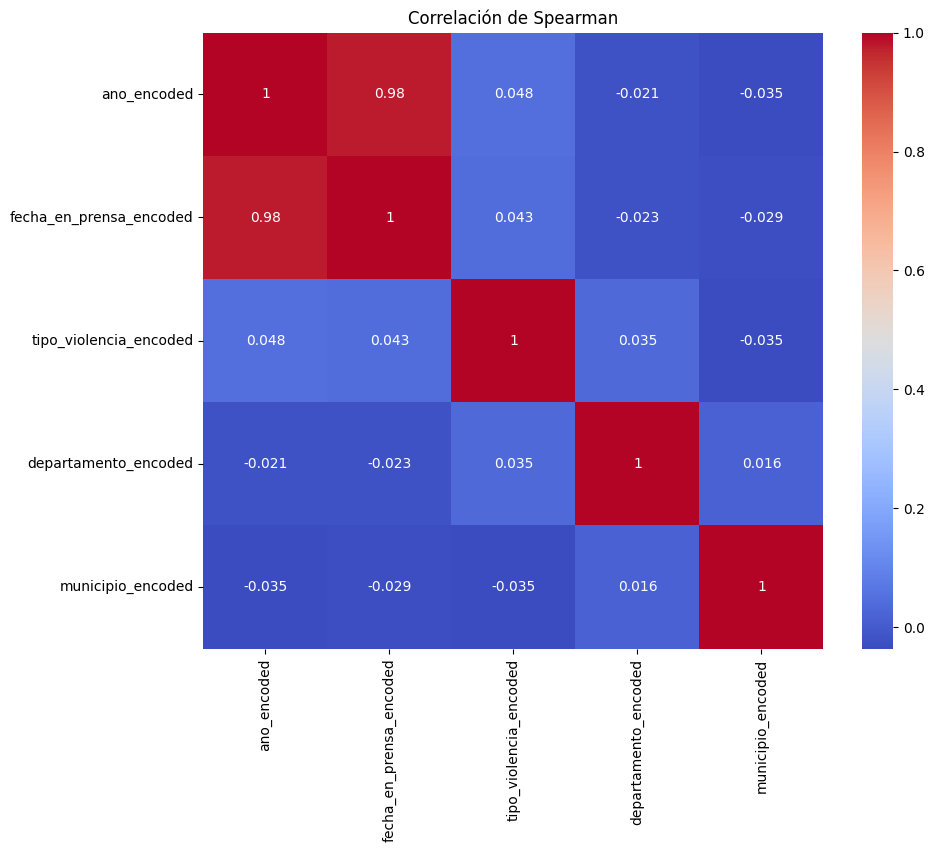

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', xticklabels=columns_to_include, yticklabels=columns_to_include)
plt.title("Correlación de Spearman")
plt.show()

Heatmap para la correlación de Kendall

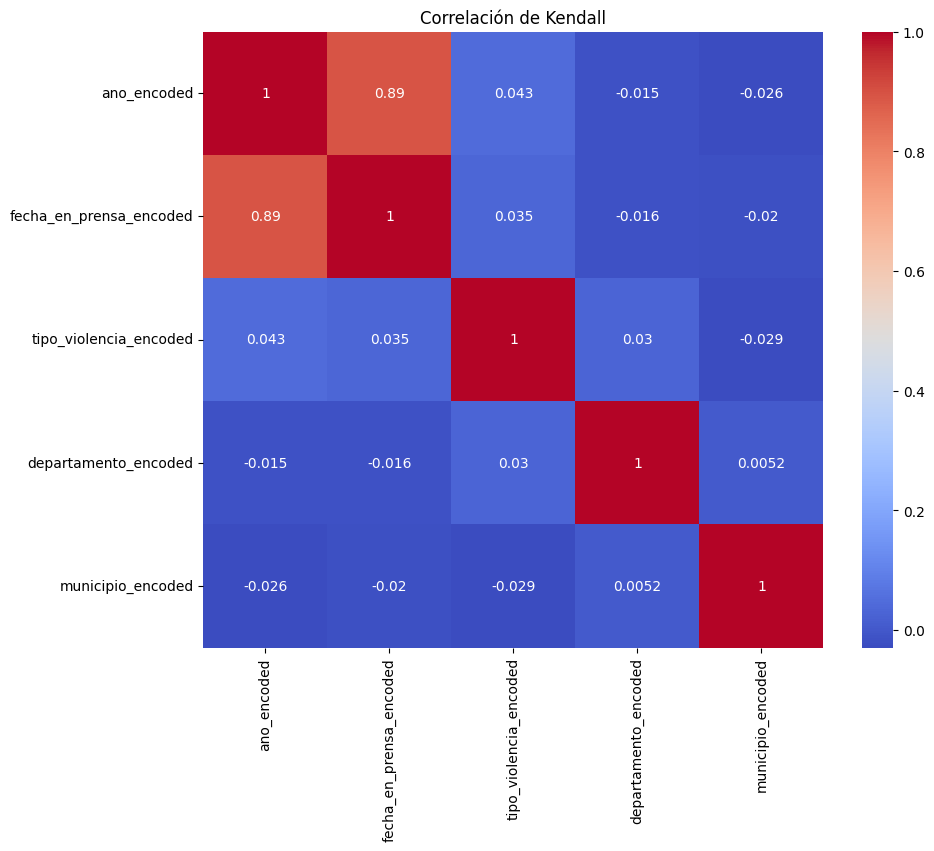

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', xticklabels=columns_to_include, yticklabels=columns_to_include)
plt.title("Correlación de Kendall")
plt.show()

In [78]:
df_2_copy.head()

,numero,ano,fecha_en_prensa,tipo_violencia,departamento,municipio,ano_encoded,fecha_en_prensa_encoded,tipo_violencia_encoded,departamento_encoded,municipio_encoded
0,1,2018,2018-01-02,FEMINICIDIO,ANTIOQUIA,HISPANIA,0,1,0,0,171
1,2,2018,2018-01-02,FEMINICIDIO,META,VILLAVICENCIO,0,1,0,18,401
2,3,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN,0,2,0,0,221
3,4,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN,0,2,0,0,221
4,5,2018,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN,0,2,0,0,221


In [79]:
columnas_a_eliminar=['numero','ano','ano_encoded','fecha_en_prensa_encoded','tipo_violencia_encoded','departamento_encoded','municipio_encoded']
df_feminicidios=df_2_copy.drop(columnas_a_eliminar, axis=1)
df_feminicidios.head()

,fecha_en_prensa,tipo_violencia,departamento,municipio
0,2018-01-02,FEMINICIDIO,ANTIOQUIA,HISPANIA
1,2018-01-02,FEMINICIDIO,META,VILLAVICENCIO
2,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN
3,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN
4,2018-01-03,FEMINICIDIO,ANTIOQUIA,MEDELLIN


Evaluación de la etica de los datos según el marco etico de desarrollo de IA en Colombia.

Consideraciones:

    Privacidad de los datos: Se ha asegurado de que no se esta incluyendo información confidencial o privada en los datos, en caso de agregarlos en un futuro se debe anonimizarlos o prescindir de ellos para preservar la etica de los datos adquiridos.

    Sesgo en los datos: Para lograr una reducción de sesgos se ha dispuesto una serie de reglas a seguir durante el desarrollo del modelo.

        Recopilar datos de manera imparcial y representativa.

        Evaluar las variables utilizadas en el modelo.

        Realizar análisis de equidad.

        Utilizar métricas de evaluación equitativas.

        Evaluar continuamente el modelo.

    Exactitud de los datos: 

        Se ha verificado la fuente de los datos, siendo el instituto de medicina legal y ciencias forenses, una institución gubernamental se espera que sigan la normativa vigente que garantiza la fiabilidad y precisión de los datos.

        Se ha realizado una limpieza y validación de los datos.

        Se ha monitoreado los datos de forma continua.

            Actualmente los datos estan desde 2015 hasta 2020. Se debe actualizar para contar con los datos hasta el mes de febrero de 2023.

        Se ha utilizado tecnicas de visualización y análisis de datos.

        Se debe revisar las decisiones del modelo.

            Evaluar la situación actual en la que se denomina como "Mujer" a las victimas actuales de feminicio para asegurar que se esta comprendiendo todo el espectro.

    Consentimiento informado: 

        Para la base de datos abiertos del gobierno en la tabla de "Conteo de Víctimas" Se asume un consentimiento previo debido a que son datos facilitados por el gobierno para la ciudadania.

        Para la base de datos del observatorio colombiano de feminicidios se ha obtenido el consentimiento previo de la organización siempre y cuando se mantenga el anonimato de las víctimas.

        

Agrupar por fecha y municipio

In [80]:
feminicidios_por_fecha_municipio=df_feminicidios.groupby(['fecha_en_prensa', 'municipio']).size().reset_index(name='count_feminicidios')

In [81]:
feminicidios_por_fecha_municipio.head()

,fecha_en_prensa,municipio,count_feminicidios
0,2011-11-29,BELLO,1
1,2018-01-02,HISPANIA,1
2,2018-01-02,VILLAVICENCIO,1
3,2018-01-03,CALI,2
4,2018-01-03,MEDELLIN,3


In [82]:
feminicidios_por_fecha_municipio = feminicidios_por_fecha_municipio.rename(columns={"municipio": "MPIO_CNMBR", "departamento": "DPTO_CNMBR"})

In [83]:
gdf_merged = colombia.merge(feminicidios_por_fecha_municipio, left_on='MPIO_CNMBR', right_on='MPIO_CNMBR', how='left')

In [84]:
gdf_merged_sorted = gdf_merged.sort_values(by='fecha_en_prensa')
gdf_merged.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,fecha_en_prensa,count_feminicidios
0,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",2018-01-03,3.0
1,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",2018-01-17,2.0
2,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",2018-02-04,1.0
3,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",2018-02-28,1.0
4,05,001,05001,ANTIOQUIA,MEDELLIN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360...",2018-03-04,1.0


In [85]:
gdf_filtered=gdf_merged.loc[gdf_merged['fecha_en_prensa'] == '2018-01-03']

In [86]:
if not gdf_filtered.empty:
    # Accede al primer registro (fila) y columna 'geometry'
    geometry_value = gdf_filtered.iloc[0]['geometry']

    # Imprime el valor de 'geometry'
    print(geometry_value)
else:
    print("No se encontraron registros con fecha_en_prensa igual a '2018-01-03'")

POLYGON ((-75.66974281299991 6.3735990120000565, -75.66964642999994 6.373597501000063, -75.66963650899993 6.37359789900006, -75.66963154099994 6.373595847000047, -75.66950665299993 6.373544335000076, -75.66913481899991 6.373390964000066, -75.66913413299994 6.373390563000044, -75.66872281799994 6.373150439000085, -75.66871834299991 6.373147352000046, -75.66852739799992 6.37301565100006, -75.66824792799991 6.372799696000072, -75.66814014199991 6.372716407000041, -75.66784970099991 6.372452371000065, -75.66761206599995 6.3722675450000565, -75.6674184389999 6.372170729000061, -75.6671881389999 6.3719785710000565, -75.66681261899993 6.371673461000057, -75.66651924399991 6.371450492000065, -75.66620239799994 6.371168852000039, -75.66607331299991 6.370957622000049, -75.66595596299993 6.370746392000058, -75.6659324929999 6.370558632000041, -75.6659324929999 6.370276993000061, -75.66587381799991 6.36980759100004, -75.66585034799994 6.369631566000066, -75.66570952799992 6.369373397000061, -75.66

In [87]:
gdf_merged['count_feminicidios'] = gdf_merged['count_feminicidios'].fillna(0)

In [88]:
def generar_malla_fecha(fecha):
    gdf_temp = gdf_merged.loc[gdf_merged['fecha_en_prensa'] == fecha]
    


In [89]:
colombia_bounds = colombia.total_bounds
colombia_polygon = box(*colombia_bounds)

In [90]:
# Definir tamaño de cuadrante en grados (1 km x 1 km aproximadamente)
grid_size = 0.01

# Calcular número de filas y columnas de cuadrantes
cols = int(np.ceil((colombia_bounds[2] - colombia_bounds[0]) / grid_size))
rows = int(np.ceil((colombia_bounds[3] - colombia_bounds[1]) / grid_size))

# Crear cuadrícula de cuadrantes
quadrants = []
for i in range(rows):
    for j in range(cols):
        quadrant = box(colombia_bounds[0] + j * grid_size, 
                       colombia_bounds[1] + i * grid_size,
                       colombia_bounds[0] + (j + 1) * grid_size,
                       colombia_bounds[1] + (i + 1) * grid_size)
        if colombia_polygon.intersects(quadrant):
            quadrants.append(quadrant.intersection(colombia_polygon))

# Unificar cuadrantes en un solo objeto MultiPolygon
quadrant_grid = unary_union(quadrants)

In [91]:
fechas_unicas = feminicidios_por_fecha_municipio['fecha_en_prensa'].unique()

for fecha in fechas_unicas:
    generar_malla_fecha(fecha)

Codificar las variables categóricas

In [92]:
le_sexo = LabelEncoder()
df['SEXO_VICTIMA_ENCODED'] = le_sexo.fit_transform(df['SEXO_VICTIMA'])

le_grupo_edad = LabelEncoder()
df['GRUPO_EDAD_VICTIMA_ENCODED'] = le_grupo_edad.fit_transform(df['GRUPO_EDAD_VICTIMA'])

le_municipio = LabelEncoder()
df['MUNICIPIO_ENCODED'] = le_municipio.fit_transform(df['MUNICIPIO'])

Recopilando lista de municipios en los que hay registros de feminicidios antes de aplicar one-hot

In [93]:
num_municipios = len(df['MUNICIPIO'].unique())
print("Hay", num_municipios, "municipios diferentes en la columna 'MUNICIPIO'.")

Hay 431 municipios diferentes en la columna 'MUNICIPIO'.


Aplicando one-hot a la columna Departamento

In [106]:
ohe_departamento = OneHotEncoder()
departamento_ohe = ohe_departamento.fit_transform(df[['DEPARTAMENTO']])
departamento_ohe_df = pd.DataFrame(departamento_ohe.toarray(), columns=ohe_departamento.get_feature_names_out(['DEPARTAMENTO']))
data = pd.concat([df, departamento_ohe_df], axis=1)

Normalización de la variable TOTAL_VICTIMAS

In [107]:

scaler = StandardScaler()
data['TOTAL_VICTIMAS'] = scaler.fit_transform(data[['TOTAL_VICTIMAS']])

Convertir a binario la columna HOMICIDIO_DOLOSO_CONSUMADO

In [108]:
df['HOMICIDIO_DOLOSO_CONSUMADO_ENCODED'] = np.where(df['HOMICIDIO_DOLOSO_CONSUMADO'] == 'Sí', 1, 0)

In [109]:
df.head()

,HECHO,RUPTURA,CONEXO,ESTADO_NOTICIA,ETAPA,ANIO_DENUNCIA,ANIO_ENTRADA,ANIO_HECHO,LEY,PAIS,...,CAPTURA,SEXO_VICTIMA,GRUPO_EDAD_VICTIMA,PAIS_NACIMIENTO,HOMICIDIO_DOLOSO_CONSUMADO,TOTAL_VICTIMAS,SEXO_VICTIMA_ENCODED,GRUPO_EDAD_VICTIMA_ENCODED,MUNICIPIO_ENCODED,HOMICIDIO_DOLOSO_CONSUMADO_ENCODED
0,SI,NO,NO,INACTIVO,EJECUCIÓN DE PENAS,2017,2017,2017,Ley 906,Colombia,...,NO,FEMENINO,JUVENTUD 18 - 28,Colombia,SI,1,0,4,155,0
1,SI,NO,NO,INACTIVO,EJECUCIÓN DE PENAS,2017,2017,2017,Ley 906,Colombia,...,SI,FEMENINO,ADULTEZ 29 - 59,Colombia,NO,2,0,1,58,0
2,SI,NO,SI,INACTIVO,INDAGACIÓN,2017,2017,2017,Ley 906,Colombia,...,NO,FEMENINO,SIN DATO,Colombia,NO,1,0,7,204,0
3,SI,NO,NO,INACTIVO,EJECUCIÓN DE PENAS,2018,2018,2018,Ley 906,Colombia,...,SI,FEMENINO,ADULTEZ 29 - 59,Colombia,NO,8,0,1,46,0
4,SI,NO,NO,INACTIVO,EJECUCIÓN DE PENAS,2015,2015,2015,Ley 906,Colombia,...,SI,FEMENINO,SIN DATO,Colombia,SI,1,0,7,95,0
